## Holonomic RRT

In [1]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from matplotlib.lines import Line2D
import itertools
import shutil
import os
import mpl_toolkits.mplot3d.axes3d as Axes3D

In [2]:
def empty_directory(path):
    if type(path) == list:
        for i in path:
            shutil.rmtree(i)
            os.mkdir(i)
    else:
        shutil.rmtree(path)
        os.mkdir(path)

In [8]:
class holonomic_RRT:
    def __init__(self,start_config,goal):
        (x0,y0,z0) = start_config
        self.xg = goal[0]
        self.yg = goal[1]
        self.zg = goal[2]
        self.x = []
        self.y = []
        self.z = []
        self.parent = []
        self.x.append(x0)
        self.y.append(y0)
        self.z.append(z0)
        
        #add other parameters required
        
        self.thrust = []
        self.theta = []
        self.phi = []
        
        self.vx = []
        self.vy = []
        self.vz = []
        self.vx.append(0)
        self.vy.append(0)
        self.vz.append(0)
        self.parent.append(0)
        
        self.T_lim = [0,30]
        self.theta_lim = [-np.pi/10,np.pi/10]
        self.phi_lim = [-np.pi/10,np.pi/10]
        
        self.i = 0
        self.del_t = 1
        
        self.count = 0
        
        # 3D boxes   lx, ly, lz, hx, hy, hz
        self.obstacles = [[-5, 25, 0, 20, 35, 60],
                     [30, 25, 0, 55, 35, 100],
                     [45, 35, 0, 55, 60, 60],
                     [45, 75, 0, 55, 85, 100],
                     [-5, 50, 0, 25, 60, 100],
                     [70, 50, 0, 80, 70, 100]]
        
        
    def acceleration_command(self,theta,phi,T):
        
        c_theta, s_theta = np.cos(theta), np.sin(theta)
        c_phi, s_phi = np.cos(phi), np.sin(phi)
        c_psi, s_psi = np.cos(0), np.sin(0)
        acc_const = T 
        g = 9.8
        
        ax = (- c_phi * s_theta * c_psi - s_phi * s_psi) * acc_const
        ay = (- c_phi * s_theta * s_psi - s_phi * c_psi) * acc_const
        az = -g + (c_phi * c_theta) * acc_const
        
        return ax, ay, az
        
    def acceleration_control(self, a, v, pos):
        """
        Convert accelerations to position
        """
        
        x = pos[0] + 0.5*a[0]*self.del_t*self.del_t + v[0]*self.del_t
        y = pos[1] + 0.5*a[1]*self.del_t*self.del_t + v[1]*self.del_t
        z = pos[2] + 0.5*a[2]*self.del_t*self.del_t + v[2]*self.del_t
        
        
        vx = v[0] + a[0]*self.del_t
        vy = v[1] + a[1]*self.del_t
        vz = v[2] + a[2]*self.del_t
        
        return [x,y,z], [vx,vy,vz] 
    
    def add_node(self,n,x,v):
        
        self.x.insert(n, x[0])
        self.y.insert(n, x[1])
        self.z.insert(n, x[2])
        
        self.vx.insert(n, v[0])
        self.vy.insert(n, v[1])
        self.vz.insert(n, v[2])
        
        return
    
    def remove_node(self,n):
        
        self.x.pop(n)
        self.y.pop(n)
        self.z.pop(n)
        
        self.vx.pop(n)
        self.vy.pop(n)
        self.vz.pop(n)
        
        return
    
    def add_edge(self,parent,child):
        self.parent.insert(child,parent)

    def remove_edge(self,n):
        self.parent.pop(n)
    
    def inside_obstacle(self,pose, box):
        x, y, z = pose
        if (x >= box[0] and x <= box[3]) and (y >= box[1] and y <= box[4]) and (z >= box[2] and z <= box[5]):
            return True
        else:
            return False
    
    def intersect_box(self,n, box):
        parent = self.parent[n]
        
        x_parent = [self.x[parent], self.y[parent], self.z[parent]]
        x_n = [self.x[n], self.y[n], self.z[n]]
        
        params = (x_parent[0] - x_n[0], x_parent[1] - x_n[1], x_parent[2] - x_n[2])
        box_size = (box[3] - box[0], box[4] - box[1], box[5] - box[2])
        
        n = np.int(np.round(np.max(np.abs(np.array(params)) / box_size))) + 1
        
        for jj in range(n+1):
            t = jj / n
            x = -params[0] * t + x_parent[0]
            y = -params[1] * t + x_parent[1]
            z = -params[2] * t + x_parent[2]
            
            if self.inside_obstacle((x, y, z), box):
                return True
        
        return False
    
    def check_node(self, n):
        for box in self.obstacles:
            if self.intersect_box(n, box):
                self.remove_edge(n)
                self.remove_node(n)
                return
        return
        
    def generate_node(self, parent, cur_vx, cur_vy, cur_vz):
        
        T = random.uniform (self.T_lim[0], self.T_lim[1])
        theta = random.uniform (self.theta_lim[0], self.theta_lim[1])
        phi = random.uniform(self.phi_lim[0], self.phi_lim[1])
        
        ax, ay, az = self.acceleration_command(theta, phi, T)
        
        [x,y,z], [vx, vy, vz] = self.acceleration_control([ax,ay,az], [cur_vx,cur_vy,cur_vz], [self.x[parent], self.y[parent], self.z[parent]])
        
        n = len(self.x)
        self.count += 1
        
        if(0<x<105 and 0<y<105 and 0<z<105):
            self.add_node(n, [x,y,z], [vx, vy, vz])
            self.add_edge(parent, n)
            self.check_node(n)
            if(len(self.x)==n+1):
                self.thrust.insert(n,T)
                self.theta.insert(n,theta)
                self.phi.insert(n,phi)
        
        return
    
    
    def expand_tree(self, ne):
        
        for num in range(len(self.x)):
            for jj in range(5):
                self.generate_node(num, self.vx[num], self.vy[num], self.vz[num])
        return
    
    # implement holonomic RRT 
    
    def path_to_goal(self):
        
        #find goal state
        tol = np.inf
        
        print(len(self.x), len(self.vx))
        
        for i in range (0,len(self.x)):
            (x,y,z)= (self.x[i],self.y[i],self.z[i])
            if (np.linalg.norm(np.array([x-self.xg,y-self.yg, z-self.zg])**2)<tol):
                self.goalstate = i
                tol = np.linalg.norm(np.array([x-self.xg,y-self.yg, z-self.zg])**2)
                if(tol<5):
                    break
        
        i = self.goalstate
        (x,y,z)= (self.x[i],self.y[i],self.z[i])
        print("THE GOAL IS")
        print(x,y, z)
        
        #add goal state to and its parent node to the path
        self.path=[]
        self.path.append(i)
        newpos=self.parent[i]
        
        #keep adding parents
        while (newpos!=0):
            self.path.append(newpos)
            newpos=self.parent[newpos]
            
        #add start state
        self.path.append(0)
        return
    
    def showpath(self, ax):
        
        for i in range (len(self.path)-1):
            n = len(self.path)-1
            n1=self.path[n-i]
            n2=self.path[n-(i+1)]
            ax.plot([self.x[n1],self.x[n2]],[self.y[n1],self.y[n2]], [self.z[n1],self.z[n2]],'bo-',lw=1,markersize=3)
            print(self.x[n1], self.y[n1], self.z[n1])
            name = 'holon_data/path/snap%s.png'%str(i)
            plt.savefig(name, dpi = 200)
            
        return
        
        
    def showthrusts(self):
        
        T = []
        theta = []
        phi = []
        
        for i in range (len(self.path)):
            n = self.path[i]
            T.append(self.thrust[n])
            theta.append(self.theta[n])
            phi.append(self.phi[n])
                
        fig,axes = plt.subplots(3,1, figsize = (10,5))
        
        time = np.arange(len(T))
        axes[0].plot(time, T)
        axes[0].set_ylabel("Thrust")
        axes[0].set_xlabel("Time")
        
        axes[1].plot(time, theta)
        axes[1].set_ylabel("Theta")
        axes[1].set_xlabel("Time")
        
        axes[2].plot(time, phi)
        axes[2].set_ylabel("Phi")
        axes[2].set_xlabel("Time")
        
        name = 'holon_data/thrusts.png'
        plt.savefig(name, dpi = 200)
        return
        
    def cuboid_data(self,box):
        l = box[3] - box[0]
        w = box[4] - box[1]
        h = box[5] - box[2]
        x = [[0, l, l, 0, 0],
             [0, l, l, 0, 0],
             [0, l, l, 0, 0],
             [0, l, l, 0, 0]]
        y = [[0, 0, w, w, 0],
             [0, 0, w, w, 0],
             [0, 0, 0, 0, 0],
             [w, w, w, w, w]]
        z = [[0, 0, 0, 0, 0],
             [h, h, h, h, h],
             [0, 0, h, h, 0],
             [0, 0, h, h, 0]]
        return box[0] + np.array(x), box[1] + np.array(y), box[2] + np.array(z)
        
    def test_env(self):
        
        # create map with obstacles
        fig = plt.figure()
        ax = Axes3D.Axes3D(fig)
        fig.add_axes(ax)
        for box in self.obstacles:
            X, Y, Z = self.cuboid_data(box)
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,color=(0.1, 0.15, 0.3, 0.2),zorder = 1)
        
        self.showpath(ax)
        self.showthrusts()


0
1
2
3
4
5
6
7
8
8
130389 130389
THE GOAL IS
78.97292620957991 79.13896890507688 97.08676803864039
0 1 0
1.2661399114914031 2.757391251017877 6.952064406821686


<ipython-input-8-44d5b69ca243>:280: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


4.472493221940522 7.348396006093974 19.80608613032453
8.54856612252659 12.892206744831217 27.8530416532228
14.438138287350421 19.312959936103518 33.22614386604393
22.171663652311118 26.81498541191381 35.68697432243978
31.970712918896947 36.195685901060706 42.47888592156167
45.43313273667977 49.39514641312261 60.059270691880045
60.91242747145152 64.35275669317802 77.02804922091825


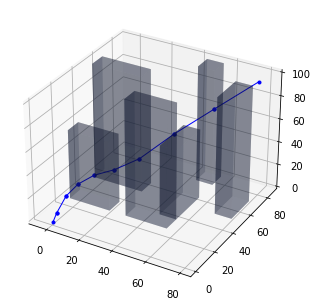

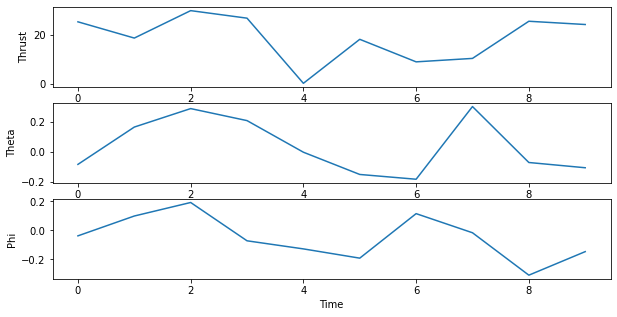

In [10]:
start = (0,1,0)
goal = (80,88,100)
nn_RRT = holonomic_RRT(start,goal)
empty_directory(['./holon_data/path','./holon_data/tree'])
for i in range(0,9):
    if (i%1==0):
        print(i)
    nn_RRT.expand_tree(i)
print(i)
nn_RRT.path_to_goal()
nn_RRT.test_env()

0
1
2
3
4
5
6
7
8
8
233168 233168
THE GOAL IS
71.39979093908806 85.5820294381287 101.02462956575648
0 1 0
2.6997830196137245 3.1628849601784053 5.542742860671792


<ipython-input-3-b7bf98dfdd7a>:280: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


7.75861010441302 8.7021441694083 19.35885649793429
13.555874227591737 16.650364661479756 36.82805217894986
20.450293055750123 25.908449554910604 50.81108371358866
27.25126241270305 35.169499746534754 55.837056642835506
33.605929061200946 45.18251437891927 55.327074677356315
42.00666512462136 55.79779904051965 57.13990316476528
54.39000973295694 70.2398459215746 71.20535039499123


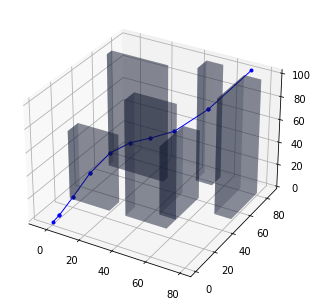

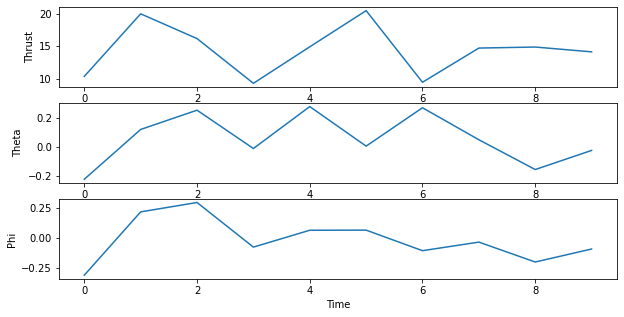

In [6]:
start = (0,1,0)
goal = (85,85,100)
nn_RRT = holonomic_RRT(start,goal)
empty_directory(['./holon_data/path','./holon_data/tree'])
for i in range(0,9):
    if (i%1==0):
        print(i)
    nn_RRT.expand_tree(i)
print(i)
nn_RRT.path_to_goal()
nn_RRT.test_env()

In [210]:

hn_RRT = holonomic_RRT(start,goal)
hn_RRT.test_env()

AttributeError: 'Axes3D' object has no property 'auto_add_to_figure'

<Figure size 432x288 with 0 Axes>